Skład grupy:
    Paweł Awramiuk
    Anna Chojnowska
    Piotr Grusza
    Szymon Leszczyński

In [1]:
## Polecenia do instalacji pakietów
# conda install -c conda-forge tensorflow
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Konfiguracje globalne
# Formatowanie liczb w DataFrame
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)

In [29]:
data_AUG = pd.read_csv("apartments_pl_2023_08.csv")
data_SEP = pd.read_csv("apartments_pl_2023_09.csv")
data_OCT = pd.read_csv("apartments_pl_2023_10.csv")

In [30]:
data_AUG.drop(columns=["id"], inplace=True)
data_AUG.drop_duplicates(inplace = True)
data_AUG.drop(columns=["schoolDistance","clinicDistance","postOfficeDistance","kindergartenDistance","restaurantDistance","collegeDistance","pharmacyDistance"], inplace=True)
data_AUG.drop(columns=["buildingMaterial","condition"], inplace=True)

data_SEP.drop(columns=["id"], inplace=True)
data_SEP.drop_duplicates(inplace = True)
data_SEP.drop(columns=["schoolDistance","clinicDistance","postOfficeDistance","kindergartenDistance","restaurantDistance","collegeDistance","pharmacyDistance"], inplace=True)
data_SEP.drop(columns=["buildingMaterial","condition"], inplace=True)

data_OCT.drop(columns=["id"], inplace=True)
data_OCT.drop_duplicates(inplace = True)
data_OCT.drop(columns=["schoolDistance","clinicDistance","postOfficeDistance","kindergartenDistance","restaurantDistance","collegeDistance","pharmacyDistance"], inplace=True)
data_OCT.drop(columns=["buildingMaterial","condition"], inplace=True)

In [31]:
missing_values = pd.concat([
        data_AUG.isna().sum(),
        data_AUG.isna().sum() / len(data_AUG) * 100,
        data_SEP.isna().sum(),
        data_SEP.isna().sum() / len(data_SEP) * 100,
        data_OCT.isna().sum(),
        data_OCT.isna().sum() / len(data_OCT) * 100
    ],
    axis=1
)
missing_values.rename(columns = {0:'AUG', 1:'AUG %',2:'SEP', 3:'SEP %',4:'OCT', 5:'OCT %',6:'ALL', 7:'ALL %'}, inplace = True)
missing_values

,AUG,AUG %,SEP,SEP %,OCT,OCT %
city,0,0.00,0,0.00,0,0.00
type,3985,21.30,3765,22.38,3728,22.54
squareMeters,0,0.00,0,0.00,0,0.00
rooms,0,0.00,0,0.00,0,0.00
floor,3394,18.14,3005,17.86,3019,18.25
floorCount,259,1.38,243,1.44,242,1.46
buildYear,3226,17.25,2906,17.27,2881,17.42
latitude,0,0.00,0,0.00,0,0.00
longitude,0,0.00,0,0.00,0,0.00
centreDistance,0,0.00,0,0.00,0,0.00


<Axes: >

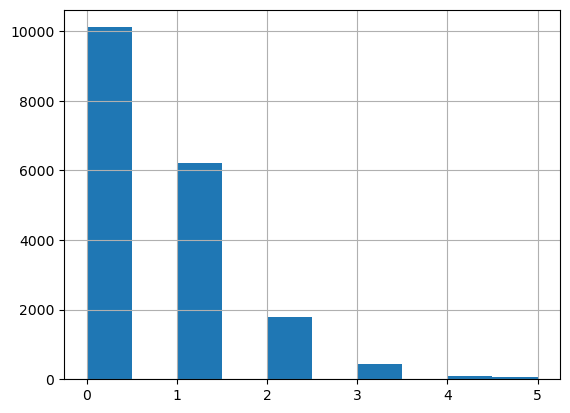

In [32]:
data_AUG.isna().sum(1).hist()

<Axes: >

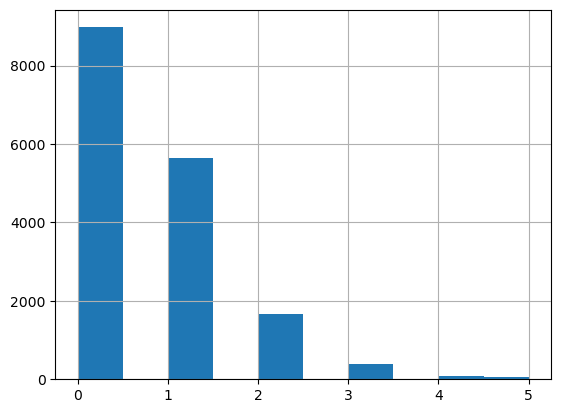

In [33]:
data_SEP.isna().sum(1).hist()

<Axes: >

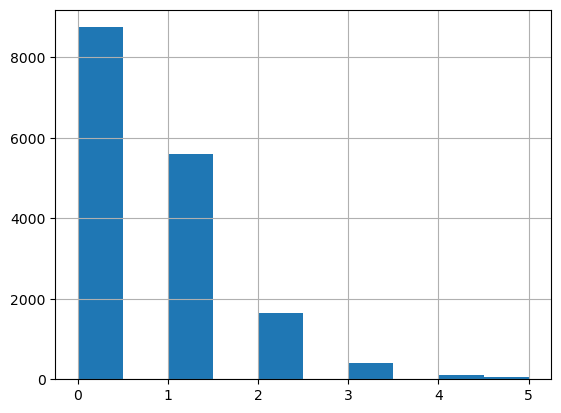

In [34]:
data_OCT.isna().sum(1).hist()

In [37]:
data_AUG = data_AUG.loc[(data_AUG.isna().sum(axis=1)<3)]
data_SEP = data_SEP.loc[(data_SEP.isna().sum(axis=1)<3)]
data_OCT = data_OCT.loc[(data_OCT.isna().sum(axis=1)<3)]

In [38]:
missing_values = pd.concat([
        data_AUG.isna().sum(),
        data_AUG.isna().sum() / len(data_AUG) * 100,
        data_SEP.isna().sum(),
        data_SEP.isna().sum() / len(data_SEP) * 100,
        data_OCT.isna().sum(),
        data_OCT.isna().sum() / len(data_OCT) * 100
    ],
    axis=1
)
missing_values.rename(columns = {0:'AUG', 1:'AUG %',2:'SEP', 3:'SEP %',4:'OCT', 5:'OCT %',6:'ALL', 7:'ALL %'}, inplace = True)
missing_values

,AUG,AUG %,SEP,SEP %,OCT,OCT %
city,0,0.00,0,0.00,0,0.00
type,3485,19.25,3313,20.35,3250,20.34
squareMeters,0,0.00,0,0.00,0,0.00
rooms,0,0.00,0,0.00,0,0.00
floor,2981,16.46,2632,16.17,2633,16.47
floorCount,54,0.30,42,0.26,41,0.26
buildYear,2722,15.03,2468,15.16,2430,15.20
latitude,0,0.00,0,0.00,0,0.00
longitude,0,0.00,0,0.00,0,0.00
centreDistance,0,0.00,0,0.00,0,0.00


## Przypisanie miesiąca do poszczególnych ofert na podstawie pliku, z którego pochodzą dane

In [ ]:
# dodanie miesiąca, w którym dana oferta sprzedaży była dostępna (wszystkie dane pochodzą z roku 2023)
data_AUG["offerMonth"] = 8
data_SEP["offerMonth"] = 9
data_OCT["offerMonth"] = 10

In [ ]:
data_ALL = pd.concat([data_AUG, data_SEP, data_OCT], ignore_index=True)

In [ ]:
data_ALL.tail()

In [ ]:
data_ALL.count()

In [ ]:
# porównanie duplikatów, z pominięciem dodanej kolumny offerMonth
data_ALL.loc[data_ALL.duplicated(data_ALL.columns.delete(data_ALL.columns.get_loc("offerMonth")))]

In [ ]:
# w poszczególnych miesiącach nie występują duplikaty tej samej oferty, ponieważ metoda duplicated() 
# nie znajduje wierszy jeśli uwzględniona zostanie kolumna "offerMonth"
data_ALL.loc[data_ALL.duplicated()]

# TODO: ta komorka moze byc zbedna po analizie danych

## Usunięcie duplikatów

In [ ]:
data_FILTERED = data_ALL.drop_duplicates(subset=["id"], keep='last')
data_FILTERED

In [ ]:
data_FILTERED.count()

In [ ]:
data_FILTERED = data_FILTERED.reset_index(drop=True)

In [ ]:
data_FILTERED